# Imports

In [1]:
MODEL_V2_001 = {
    "path": 'models/V2.2.001.h5',
    "test_accuracy": None,
    "test_f1": None,
    "test_loss": None,
    "test_IOU": None
}
MODEL_TO_IMPORT = MODEL_V2_001 # can be either a model (dict) or a string

DEFAULT = {
    "mode": 'rgb',
    "seed": 1000,
    "lk_alpha": .1,
    "channels_size": 3,
}
IMAGE_SIZE = 608
PATCH_SIZE = 16
PTHRESHOLD = 0.25
NB_TST_IMG = 50

#MODEL_TO_IMPORT = 'models/V2.2.001.h5'

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import re
from IPython import display

# Load Model

In [3]:
def get_model_prop(prop_name):
    if isinstance(MODEL_TO_IMPORT, str) or prop_name not in MODEL_TO_IMPORT:
        return DEFAULT[prop_name]
    return MODEL_TO_IMPORT[prop_name]

In [4]:
from CNNv2 import CNN

model = CNN(
    rootdir='.',
    window_size=IMAGE_SIZE,
    lk_alpha=get_model_prop('lk_alpha'),
    random_seed=get_model_prop('seed'),
    channels_size=get_model_prop('channels_size'),
)
model.load(MODEL_TO_IMPORT if isinstance(MODEL_TO_IMPORT, str) else MODEL_TO_IMPORT['path'])
test_dir = "test_set_images/test_"

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 608, 608, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________

# Visualization 

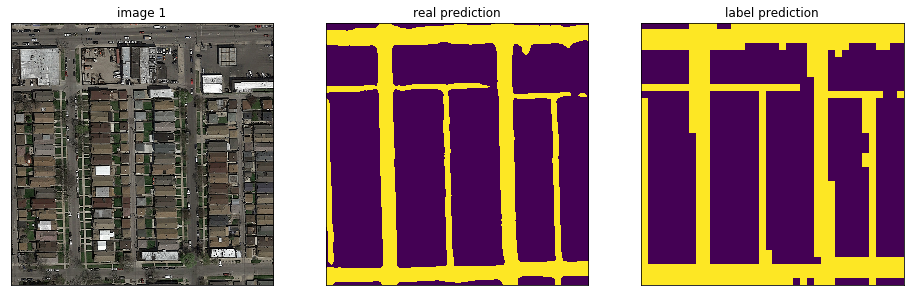

In [5]:
from helpers import *
from skimage.color import rgb2hsv, rgb2lab, rgb2hed, rgb2yuv

def load_image(filename, mode = 'rgb'):
    if mode == 'hsv':
        img = rgb2hsv(mpimg.imread(filename))
    elif mode == 'lab':
        img = rgb2lab(mpimg.imread(filename))
    elif mode == 'hed':
        img = rgb2hed(mpimg.imread(filename))
    elif mode == 'yuv':
        img = rgb2yuv(mpimg.imread(filename))
    elif mode == 'rgb':
        img = mpimg.imread(filename)
    else:
        raise NotImplemented
    return np.expand_dims(img, axis=0)

def get_path_for_img_nb(img_nb):
    return 'test_set_images/test_'+str(img_nb)+'/test_' + str(img_nb) + '.png'

def get_image_filenames(img_nb = None):
    image_filenames = []
    if img_nb == None:
        for i in range(1, NB_TST_IMG+1):
            image_filenames += [get_path_for_img_nb(i)]
    elif type(img_nb) is int:
        image_filenames += [get_path_for_img_nb(img_nb)]
    else:
        for i in img_nb:
            image_filenames += [get_path_for_img_nb(i)]
    return image_filenames
    
def visualize_step(idx, input_image, Xi_raw, Xi, ground, animate = False):
    input_image = np.squeeze(input_image)
    fig, axs = plt.subplots(1,3, figsize=(16, 16))
    axs[0].imshow(input_image)
    axs[0].set_title(f'image {idx+1}')
    axs[1].imshow(np.squeeze(Xi))
    axs[1].set_title('real prediction')
    axs[2].imshow(ground)
    axs[2].set_title('label prediction')
    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    display.clear_output(wait=True)
    if animate:
        plt.show()

def get_predicted_mask(image_filename, mode):
    input_image = load_image(image_filename, mode)
    Xi_raw = model.model.predict(input_image)
    Xi = np.where(Xi_raw>0.5, 1, 0)
    Xi = np.squeeze(Xi)
    return Xi_raw, Xi

def visualize(img_nb = None, mode = 'rgb', save_masks = False):
    image_filenames = get_image_filenames(img_nb)
    for i, filename in enumerate(image_filenames[0:]):
        img_input = load_image(filename, mode)
        Xi_raw, Xi = get_predicted_mask(filename, mode)
        ground = get_ground_img(Xi, patch_size = PATCH_SIZE, foreground_threshold = PTHRESHOLD)
        visualize_step(i, img_input, Xi_raw, Xi, ground)
        if save_masks:
            mpimg.imsave(os.path.join('./masks', f'test_{i+1}.png'), np.squeeze(Xi_raw[0]))
    plt.show()
        
def generate_submission(img_nb = None, submission_filename = "submission.csv", mode = DEFAULT['mode']):
    """ Generate a .csv containing the classification of the test set. """
    image_filenames = get_image_filenames(img_nb)
    print(f'Generating file: {submission_filename}...')
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i, filename in enumerate(image_filenames[0:]):
            img_input = load_image(filename, mode)
            Xi_raw, Xi = get_predicted_mask(filename, mode)
            ground = get_ground_img(Xi, patch_size = PATCH_SIZE, foreground_threshold = PTHRESHOLD)
            visualize_step(i, img_input, Xi_raw, Xi, ground, True)
            f.writelines([
                "{:03d}_{}_{},{}\n".format(i+1, k, j, ground[j,k])
                for j,k in zip(range(ground.shape[0]), range(ground.shape[1]))
            ])
    print(f'Submission generated at {submission_filename}!')

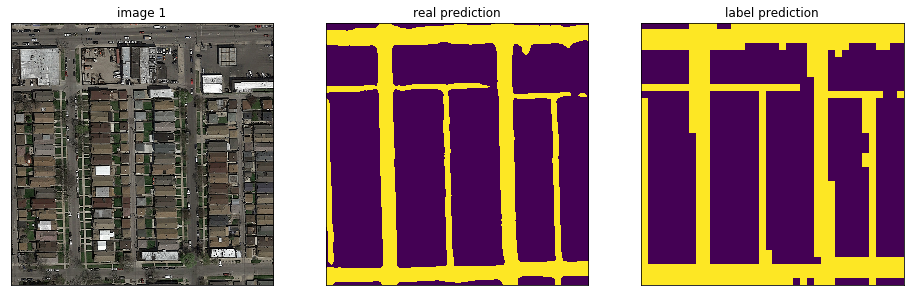

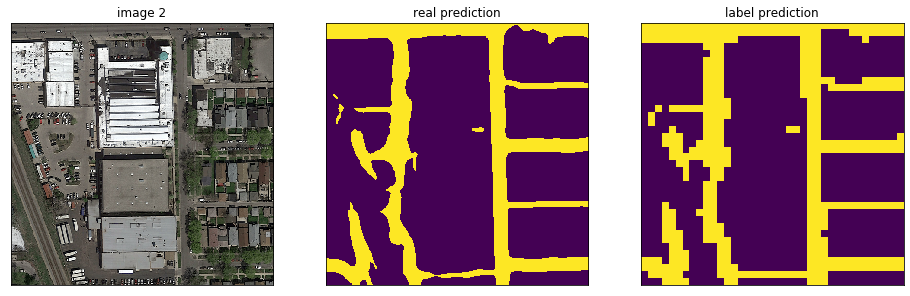

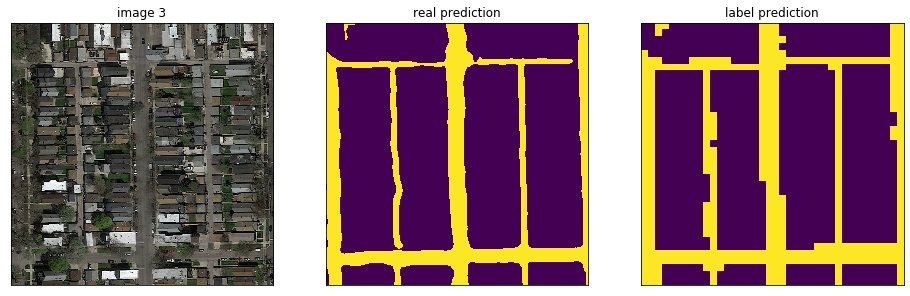

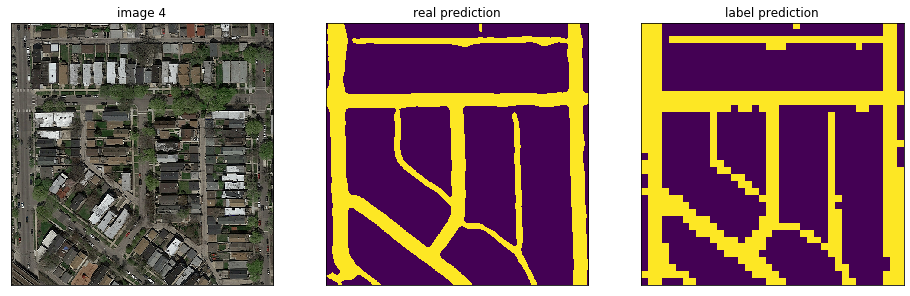

In [6]:
#Visualize prediction on input image
# Parameters idx can be:
#     int: 1-50 for a specific image
#     array: [1,2,4,6] for a specific range
#     None: run all images
visualize([1,2,6,10])

# Submission

In [7]:
assert True == False, "prevent next cells execution when run all"

AssertionError: prevent next cells execution when run all

In [ ]:
generate_submission(mode=get_model_prop('mode'))